In [59]:
import os
import pydicom
from tqdm import tqdm 
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchsummary import summary
import segmentation_models_pytorch as smp
import gc
import random

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [2]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [3]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [49]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300, 0]

In [5]:
badset = {'97.dcm', '95.dcm', '178.dcm'}

In [50]:
train_images = []
train_masks = []
val_images = []
val_masks = []

def fill_arr(img_dir, img_bucket,filetype='.dcm'):
    for jpg_name in tqdm(os.listdir(img_dir)):
        filename = jpg_name.split('.')[0] + filetype
        img = load_dicom(os.path.join(dicom_dir, filename)) if filetype == '.dcm' else load_mask(os.path.join(anno_dir, filename))
        img_bucket.append(img)

fill_arr(image_train_dir, train_images)
fill_arr(image_val_dir, val_images)
fill_arr(label_train_dir, train_masks, filetype='.nii.gz')
fill_arr(image_val_dir, val_masks, filetype='.nii.gz')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 60.57it/s]


In [51]:
def plot_mosaic(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0, 0].imshow(img1)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img2)
    axes[0, 1].axis('off')

    axes[1, 0].imshow(img3)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img4)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

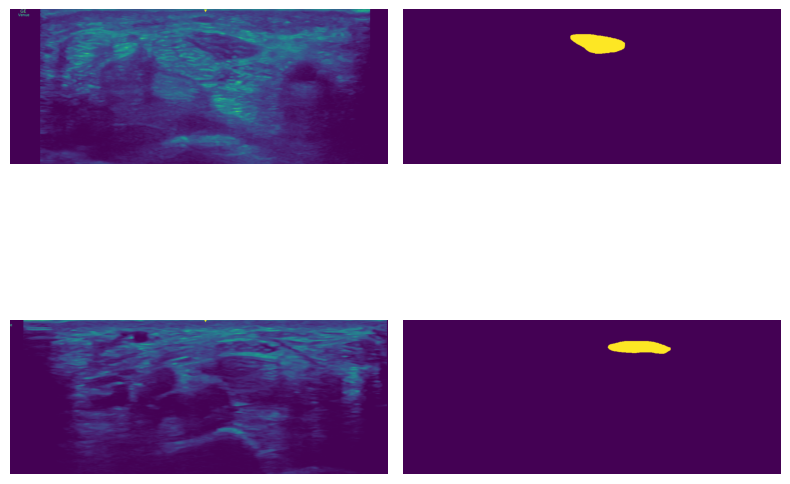

In [52]:
plot_mosaic(train_images[0], train_masks[0], val_images[0], val_masks[0])

In [66]:
class segmentationDataset(torch.utils.data.Dataset):
  """
  Dataset class for segmentation task.
  """
  def __init__(self, image_arr, seg_arr, split='train'):
    self.imgs = image_arr
    self.segs = seg_arr
    self.split = split


  def __len__(self):
    return len(self.imgs)


  def __getitem__(self, idx):
    img = torch.tensor(self.imgs[idx], dtype=torch.float32) / 255.0
    seg = torch.tensor(self.segs[idx])
    img = img.unsqueeze(0)
    seg = seg.unsqueeze(0)


    image_transform = T.Compose([
        T.Normalize(mean=[0.5], std=[0.5]),
        T.Resize((512, 512)),
    ])

    mask_transform = T.Compose([
        T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),  # Nearest-neighbor for masks

    ])

    # if self.split == 'train':
    #   if random.random() < 0.5:
    #     img = F.hflip(img)
    #     seg = F.hflip(seg)


    return image_transform(img), mask_transform(seg)

In [65]:
train_masks[0].dtype

dtype('uint16')

In [67]:
train_dataset = segmentationDataset(train_images, train_masks)
val_dataset = segmentationDataset(val_images, val_masks, split='val')
train_dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = 32,
    shuffle     = True
)

val_dtl = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False
)

In [68]:
for i, data in enumerate(train_dtl):
    imgs_batch, segs_batch = data
    print(imgs_batch.shape)
    print(segs_batch.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512])


In [71]:
import gc
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [84]:
EPOCHS = 40
unet_model = smp.Unet(in_channels=1).to(device)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.AdamW(unet_model.parameters(),
                              lr=3e-2,
                              weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= 10,
        eta_min=5e-5)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_2776176/4032090692.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [85]:
def save_model(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [86]:
unet_root = 'unet_runs'
os.makedirs(unet_root, exist_ok=True)

In [87]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [88]:
def train_loop(dtl, model, criterion, optimzer, scheduler, scaler):
  model.train()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.cuda.amp.autocast():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    scaler.scale(loss).backward()
    scaler.step(optimzer)
    scaler.update()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  scheduler.step()
  print("Train loss: {:.04f}\t Learning rate: {:.04f}".format(loss_m.avg, float(optimizer.param_groups[0]['lr'])))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))



In [89]:
def val_loop(dtl, model, criterion):
  model.eval()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.inference_mode():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  print("Val loss: {:.04f}".format(loss_m.avg))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))

  return dataset_iou

In [90]:
gc.collect()
torch.cuda.empty_cache()

In [91]:
best_iou = 0
best_epoch = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1} / {EPOCHS}')
  train_loop(train_dtl, unet_model, criterion, optimizer, scheduler, scaler)
  val_iou=val_loop(val_dtl, unet_model, criterion)
  if val_iou > best_iou:
    best_iou = val_iou
    best_epoch = epoch
  save_model(unet_model, optimizer, scheduler, epoch, os.path.join(unet_root, f"epoch_{epoch+1}.pth"))

Epoch 1 / 40


/tmp/ipykernel_2776176/961452595.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                                                                                              

Train loss: 0.9552	 Learning rate: 0.0293
per image IOU: 0.0289
per dataset IOU: 0.0265


Val loss: 0.9607
per image IOU: 0.0200
per dataset IOU: 0.0200
Epoch 2 / 40


Train loss: 0.8912	 Learning rate: 0.0271
per image IOU: 0.0797
per dataset IOU: 0.0680


Val loss: 0.9607
per image IOU: 0.0200
per dataset IOU: 0.0200
Epoch 3 / 40


Train loss: 0.7913	 Learning rate: 0.0238
per image IOU: 0.1387
per dataset IOU: 0.1354


Val loss: 0.9832
per image IOU: 0.0085
per dataset IOU: 0.0085
Epoch 4 / 40


Train loss: 0.6826	 Learning rate: 0.0197
per image IOU: 0.2121
per dataset IOU: 0.2115


Val loss: 0.9969
per image IOU: 0.0020
per dataset IOU: 0.0015
Epoch 5 / 40


Train loss: 0.6927	 Learning rate: 0.0150
per image IOU: 0.1918
per dataset IOU: 0.1699


Val loss: 0.8817
per image IOU: 0.0628
per dataset IOU: 0.0629
Epoch 6 / 40


Train loss: 0.6235	 Learning rate: 0.0104
per image IOU: 0.2373
per dataset IOU: 0.2349


Val loss: 0.9567
per image IOU: 0.0221
per dataset IOU: 0.0221
Epoch 7 / 40


Train loss: 0.6072	 Learning rate: 0.0062
per image IOU: 0.2607
per dataset IOU: 0.2453


Val loss: 0.9427
per image IOU: 0.0295
per dataset IOU: 0.0295
Epoch 8 / 40


Train loss: 0.5794	 Learning rate: 0.0029
per image IOU: 0.2839
per dataset IOU: 0.2678


Val loss: 0.8682
per image IOU: 0.0740
per dataset IOU: 0.0704
Epoch 9 / 40


Train loss: 0.5749	 Learning rate: 0.0008
per image IOU: 0.2865
per dataset IOU: 0.2706


Val loss: 0.7568
per image IOU: 0.1443
per dataset IOU: 0.1381
Epoch 10 / 40


Train loss: 0.5769	 Learning rate: 0.0001
per image IOU: 0.2851
per dataset IOU: 0.2705


Val loss: 0.6634
per image IOU: 0.2062
per dataset IOU: 0.2021
Epoch 11 / 40


Train loss: 0.5744	 Learning rate: 0.0008
per image IOU: 0.2862
per dataset IOU: 0.2713


Val loss: 0.6073
per image IOU: 0.2449
per dataset IOU: 0.2441
Epoch 12 / 40


Train loss: 0.5707	 Learning rate: 0.0029
per image IOU: 0.2885
per dataset IOU: 0.2729


Val loss: 0.5736
per image IOU: 0.2659
per dataset IOU: 0.2714
Epoch 13 / 40


Train loss: 0.5719	 Learning rate: 0.0062
per image IOU: 0.2924
per dataset IOU: 0.2750


Val loss: 0.5741
per image IOU: 0.2610
per dataset IOU: 0.2709
Epoch 14 / 40


Train loss: 0.5729	 Learning rate: 0.0104
per image IOU: 0.2942
per dataset IOU: 0.2722


Val loss: 0.5913
per image IOU: 0.2469
per dataset IOU: 0.2575
Epoch 15 / 40


Train loss: 0.5776	 Learning rate: 0.0150
per image IOU: 0.2905
per dataset IOU: 0.2684


Val loss: 0.5757
per image IOU: 0.2613
per dataset IOU: 0.2702
Epoch 16 / 40


Train loss: 0.5670	 Learning rate: 0.0197
per image IOU: 0.2957
per dataset IOU: 0.2771


Val loss: 0.5685
per image IOU: 0.2662
per dataset IOU: 0.2761
Epoch 17 / 40


Train loss: 0.5687	 Learning rate: 0.0238
per image IOU: 0.2895
per dataset IOU: 0.2735


Val loss: 0.5918
per image IOU: 0.2517
per dataset IOU: 0.2573
Epoch 18 / 40


Train loss: 0.5710	 Learning rate: 0.0271
per image IOU: 0.2943
per dataset IOU: 0.2748


Val loss: 0.5854
per image IOU: 0.2539
per dataset IOU: 0.2623
Epoch 19 / 40


Train loss: 0.5638	 Learning rate: 0.0293
per image IOU: 0.2973
per dataset IOU: 0.2785


Val loss: 0.6172
per image IOU: 0.2370
per dataset IOU: 0.2375
Epoch 20 / 40


Train loss: 0.5664	 Learning rate: 0.0300
per image IOU: 0.2923
per dataset IOU: 0.2773


Val loss: 0.5974
per image IOU: 0.2497
per dataset IOU: 0.2530
Epoch 21 / 40


Train loss: 0.5675	 Learning rate: 0.0293
per image IOU: 0.2950
per dataset IOU: 0.2784


Val loss: 0.7262
per image IOU: 0.1660
per dataset IOU: 0.1600
Epoch 22 / 40


Train loss: 0.5729	 Learning rate: 0.0271
per image IOU: 0.2921
per dataset IOU: 0.2742


Val loss: 0.7652
per image IOU: 0.1350
per dataset IOU: 0.1338
Epoch 23 / 40


Train loss: 0.5607	 Learning rate: 0.0238
per image IOU: 0.2996
per dataset IOU: 0.2812


Val loss: 0.6155
per image IOU: 0.2285
per dataset IOU: 0.2383
Epoch 24 / 40


Train loss: 0.5523	 Learning rate: 0.0197
per image IOU: 0.3006
per dataset IOU: 0.2864


Val loss: 0.9960
per image IOU: 0.0025
per dataset IOU: 0.0020
Epoch 25 / 40


Train loss: 0.5516	 Learning rate: 0.0150
per image IOU: 0.2989
per dataset IOU: 0.2883


Val loss: 0.9832
per image IOU: 0.0090
per dataset IOU: 0.0085
Epoch 26 / 40


Train loss: 0.5540	 Learning rate: 0.0104
per image IOU: 0.3134
per dataset IOU: 0.2894


Val loss: 0.9944
per image IOU: 0.0033
per dataset IOU: 0.0029
Epoch 27 / 40


Train loss: 0.5513	 Learning rate: 0.0062
per image IOU: 0.3152
per dataset IOU: 0.2921


Val loss: 0.9915
per image IOU: 0.0048
per dataset IOU: 0.0043
Epoch 28 / 40


Train loss: 0.5416	 Learning rate: 0.0029
per image IOU: 0.3201
per dataset IOU: 0.3004


Val loss: 0.9822
per image IOU: 0.0084
per dataset IOU: 0.0090
Epoch 29 / 40


Train loss: 0.5341	 Learning rate: 0.0008
per image IOU: 0.3311
per dataset IOU: 0.3092


Val loss: 0.9152
per image IOU: 0.0420
per dataset IOU: 0.0449
Epoch 30 / 40


Train loss: 0.5265	 Learning rate: 0.0001
per image IOU: 0.3368
per dataset IOU: 0.3156


Val loss: 0.8207
per image IOU: 0.0977
per dataset IOU: 0.0990
Epoch 31 / 40


Train loss: 0.5229	 Learning rate: 0.0008
per image IOU: 0.3366
per dataset IOU: 0.3132


Val loss: 0.7538
per image IOU: 0.1431
per dataset IOU: 0.1410
Epoch 32 / 40


Train loss: 0.5220	 Learning rate: 0.0029
per image IOU: 0.3359
per dataset IOU: 0.3137


Val loss: 0.6856
per image IOU: 0.1906
per dataset IOU: 0.1870
Epoch 33 / 40


Train loss: 0.5128	 Learning rate: 0.0062
per image IOU: 0.3435
per dataset IOU: 0.3216


Val loss: 0.6222
per image IOU: 0.2260
per dataset IOU: 0.2333
Epoch 34 / 40


Train loss: 0.5191	 Learning rate: 0.0104
per image IOU: 0.3390
per dataset IOU: 0.3161


Val loss: 0.7420
per image IOU: 0.1475
per dataset IOU: 0.1490
Epoch 35 / 40


Train loss: 0.5206	 Learning rate: 0.0150
per image IOU: 0.3382
per dataset IOU: 0.3164


Val loss: 0.8531
per image IOU: 0.0826
per dataset IOU: 0.0799
Epoch 36 / 40


Train loss: 0.5243	 Learning rate: 0.0197
per image IOU: 0.3357
per dataset IOU: 0.3183


Val loss: 0.8197
per image IOU: 0.0955
per dataset IOU: 0.0993
Epoch 37 / 40


Train loss: 0.5372	 Learning rate: 0.0238
per image IOU: 0.3284
per dataset IOU: 0.3055


Val loss: 1.0000
per image IOU: 0.0000
per dataset IOU: 0.0000
Epoch 38 / 40


Train loss: 0.5343	 Learning rate: 0.0271
per image IOU: 0.3200
per dataset IOU: 0.3047


Val loss: 0.8264
per image IOU: 0.0861
per dataset IOU: 0.0951
Epoch 39 / 40


Train loss: 0.5433	 Learning rate: 0.0293
per image IOU: 0.3110
per dataset IOU: 0.2958


Val loss: 0.8659
per image IOU: 0.0630
per dataset IOU: 0.0719
Epoch 40 / 40


Train loss: 0.5406	 Learning rate: 0.0300
per image IOU: 0.3189
per dataset IOU: 0.2993


Val loss: 1.0000
per image IOU: 0.0000
per dataset IOU: 0.0000
